# CS/ECE/ISyE 524 - Spr 2018 - HW 6 - Solutions
### Prepared by: Laurent Lessard

## 1. Voltage smoothing

Voltage smoothing. We would like to send a sequence of voltage inputs to the manipulator
arm of a robot. The desired signal is shown in the plot below (also available in `voltages.csv`)

Unfortunately, abrupt changes in voltage cause undue wear and tear on the motors over time, so we
would like to modify the signal so that the transitions are smoother. If the voltages above are given
by $v_1, v_2, \dots , v_{200}$, one way to characterize smoothness is via the sum of squared differences:
$$
R(v) = (v_2 - v_1)^2 + (v_3 - v_2)^2 + \dots + (v_{200} - v_{199})^2
$$
When $R(v)$ is smaller, the voltage is smoother. Solve a regularized least squares problem that explores the tradeoff between matching the desired signal perfectly and making the signal smooth. Include a plot comparing the original signal to a few different smoothed versions obtained using regularized least squares and with varying degrees of smoothness.

In [1]:
# Read Data
v = readcsv("voltages.csv")
n = length(v)
x = 1:n

# try a variety of different regularization weights
lambdavals = [0.1, 0.5, 1, 5, 10]
k = length(lambdavals)
y = zeros(n,k)

using JuMP, Gurobi
for (i,lambda) = enumerate(lambdavals)
    m = Model(solver=GurobiSolver(OutputFlag=0))
    @variable(m, optv[1:n])
    
    @expression(m, LS, sum((v[i] - optv[i])^2 for i = 1:n))
    @expression(m, Rsmooth, sum((optv[i+1] - optv[i])^2 for i = 1:n-1))
    
    @objective(m, Min, LS + lambda*Rsmooth)
    
    solve(m)
    y[:,i] = getvalue(optv)
end


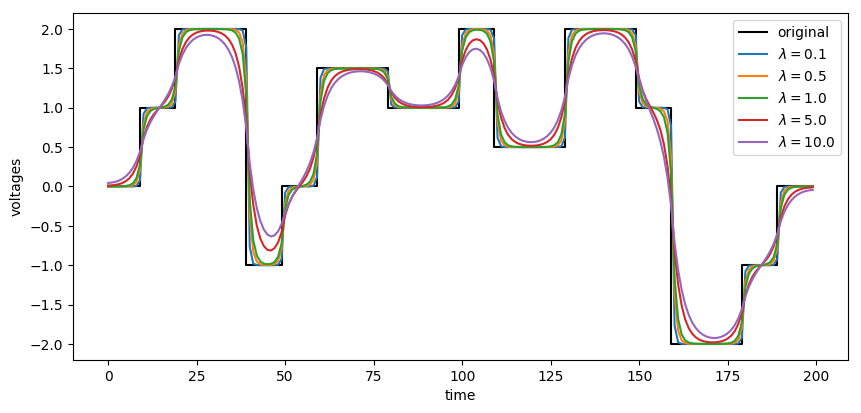

In [16]:
using PyPlot
figure(figsize=(10,4.5))
step(v,"k-",label="original")
for (i,lambda) = enumerate(lambdavals)
    plot(y[:,i],label=string(L"\lambda = ", lambda))
end
legend(loc ="best")
ylabel("voltages")
xlabel("time");

## 2. Quadratic form positivity

You're presented with the constraint:
\begin{equation}
2x^2 + 2y^2 + 9z^2 + 8xy -6xz - 6yz \le 1 \hspace{2cm} (1)
\end{equation}

**a)** Write the constraint (1) in the standard form $v^\mathsf{T} Q v \le 1$. Where $Q$ is a symmetric matrix. What is $Q$ and what is $v$?	
	
**b)** It turns out the above constraint is _not_ convex. In other words, the set of $(x,y,z)$ satisfying the constraint (1) is not an ellipsoid. Explain why this is the case.

**Note:** you can perform an orthogonal decomposition of a symmetric matrix $Q$ in Julia like this:
```
(L,U) = eig(Q)      # L is the vector of eigenvalues and U is orthogonal
U * diagm(L) * U'   # this is equal to Q (as long as Q was symmetric to begin with)
```

**c)** We can also write the constraint (1) using norms by putting it in the form:
\begin{equation}
\|Av\|^2 - \|Bv\|^2 \le 1
\end{equation}
What is $v$ and what are the matrices $A$ and $B$ that make the constraint above equivalent to (1)?

**d)** Explain how to find $(x,y,z)$ that satisfies the constraint (1) and that has arbitrarily large magnitude (i.e. $x^2+y^2+z^2$ is as large as you like).


**Solution to part a):** By inspection, the matrix $Q$ is:
\begin{equation}
Q = \begin{bmatrix} 2 & 4 & -3 \\ 4 & 2 & -3 \\ -3 & -3 & 9 \end{bmatrix}
\end{equation}
and $v$ is the vector $(x,y,z)$.

**Solution to part b)** We can figure out whether it's an ellipsoid by seeing if the eigenvalues are all nonnegative. Since one of the eigenvalues is strictly nonnegative, Q is indefinite. The constraint is therefore not an ellipsoid. See below.

In [8]:
Q = [2 4 -3; 4 2 -3; -3 -3 9]
(L,U) = eig(Q);
L

3-element Array{Float64,1}:
 -2.0
  3.0
 12.0

**Solution to part c)** We can split the constraint into two pieces by separating the positive eigenvalues from the negative ones. Since the eigenvalues are $\{-2,3,12\}$, our decomposition looks like:
\begin{align}
Q &= -2 u_1 u_1^\mathsf{T}+3 u_2 u_2^\mathsf{T}+12 u_3 u_3^\mathsf{T} \\
&= \left(3 u_2 u_2^\mathsf{T}+12 u_3 u_3^\mathsf{T}\right) - \left( 2 u_1 u_1^\mathsf{T} \right) \\
&= \begin{bmatrix}u_2 & u_3\end{bmatrix} \begin{bmatrix}3 & 0 \\ 0 & 12\end{bmatrix} \begin{bmatrix}u_2 & u_3\end{bmatrix}^\mathsf{T} - \begin{bmatrix}u_1\end{bmatrix} \begin{bmatrix}2\end{bmatrix} \begin{bmatrix}u_1\end{bmatrix}^\mathsf{T}
\end{align}
So this looks something like $U_1 Q_1 U_1^\mathsf{T} - U_2 Q_2 U_2^\mathsf{T}$, which is almost what we need. We want this to look like $A^\mathsf{T}A - B^\mathsf{T}B$. So one way to do this is to set:
\begin{equation}
A = \begin{bmatrix}\sqrt3 & 0 \\ 0 & \sqrt{12}\end{bmatrix}\begin{bmatrix}u_2 & u_3\end{bmatrix}^\mathsf{T}
\qquad\text{and}\qquad
B = \sqrt{2}\, u_1^\mathsf{T}
\end{equation}
with $v = (x,y,z)$ as before. Let's test that it gives the correct result for a random point:

In [32]:
srand(0)  # random seed
Q = [2 4 -3; 4 2 -3; -3 -3 9]
(L,U) = eig(Q);
v = randn(3,1);

A = diagm([sqrt.(3),sqrt.(12)])*U[:,[2,3]]'
B = sqrt.(2)*U[:,1]'
println("A is equal to:", A)
println("B is equal to:", B)
println("v'Qv = ", (v'*Q*v)[1])
println("|Av|^2 - |Bv|^2 = ", norm(A*v)^2 - norm(B*v)^2)

A is equal to:[-1.0 -1.0 -1.0; -1.41421 -1.41421 2.82843]
B is equal to:[1.0 -1.0 0.0]
v'Qv = 11.110089817795842
|Av|^2 - |Bv|^2 = 11.110089817795835


**Alternative solution to part c)** We can do a similar split but by keeping the entire matrix together:
\begin{align}
Q &= U \begin{bmatrix}-2 & 0 & 0 \\ 0 & 3 & 0 \\ 0 & 0 & 12 \end{bmatrix} U^\mathsf{T} \\
&= U \begin{bmatrix}0 & 0 & 0 \\ 0 & 3 & 0 \\ 0 & 0 & 12 \end{bmatrix} U^\mathsf{T} - U \begin{bmatrix}2 & 0 & 0 \\ 0 & 0 & 0 \\ 0 & 0 & 0 \end{bmatrix} U^\mathsf{T}
\end{align}
So this looks something like $U Q_1 U^\mathsf{T} - U Q_2 U^\mathsf{T}$, where the $U$ matrices are square and orthogonal. We can find $A$ and $B$ by doing a matrix square root! This results in:
\begin{equation}
A = U \begin{bmatrix}0 & 0 & 0 \\ 0 & \sqrt{3} & 0 \\ 0 & 0 & \sqrt{12} \end{bmatrix} U^\mathsf{T}
\qquad\text{and}\qquad
B = U \begin{bmatrix}\sqrt{2} & 0 & 0 \\ 0 & 0 & 0 \\ 0 & 0 & 0 \end{bmatrix} U^\mathsf{T}
\end{equation}
with $v = (x,y,z)$ as before. Let's test that it gives the correct result for a random point:

In [34]:
A = U * diagm([0, sqrt.(3), sqrt.(12)]) * U'
B = U * diagm([sqrt.(2), 0, 0]) * U'
println("A is equal to:", A)
println("B is equal to:", B)
println("v'Qv = ", (v'*Q*v)[1])
println("|Av|^2 - |Bv|^2 = ", norm(A*v)^2 - norm(B*v)^2)

A is equal to:[1.1547 1.1547 -0.57735; 1.1547 1.1547 -0.57735; -0.57735 -0.57735 2.88675]
B is equal to:[0.707107 -0.707107 0.0; -0.707107 0.707107 0.0; 0.0 -0.0 0.0]
v'Qv = 11.110089817795842
|Av|^2 - |Bv|^2 = 11.110089817795833


**Solution to part d)** We can make the quadratic form negative. Once we can do that for some $v$, then any scalar multiple of that $v$ will lead to a _more_ negative result, which will still satisfy the constraint. In this case, it amounts to using any $v$ in the directly of $u_1$, since that leads to:
\begin{equation}
u_1^\mathsf{T} Q u_1 = u_1^\mathsf{T} U \begin{bmatrix}-2 & 0 & 0 \\ 0 & 3 & 0 \\ 0 & 0 & 12 \end{bmatrix} U^\mathsf{T} u_1 = -2
\end{equation}
So let's compute $u_1$:

In [36]:
Q = [2 4 -3; 4 2 -3; -3 -3 9]
(L,U) = eig(Q);

println("The following (x,y,z) makes the quadratic form negative:")
vbad = U[:,1]
display(vbad)

# let's verify that it actually makes the quadratic form negative. We can take any multiple of this
println("Value of quadratic form for this v")
sleep(.1)
x,y,z = vbad
display(2x^2 + 2y^2 + 9z^2 + 8x*y -6x*z - 6y*z)

3-element Array{Float64,1}:
  0.707107
 -0.707107
  0.0     

The following (x,y,z) makes the quadratic form negative:
Value of quadratic form for this v


-2.0

Now we have this value $v_\text{bad}$ with norm $1$ that leads to $v_\text{bad}^\mathsf{T}Qv_\text{bad} = -2 \le 1$. Therefore, if we scale it by some $t > 0$, we get a norm of $t$ and $(v_\text{bad}t)^\mathsf{T}Q(v_\text{bad}t) = -2t \le 1$. So we can make this vector as large as we want in norm by scaling it and it will still satisfy the constraint.

## 3. Lasso regression

Consider the data $(x,y)$ plotted below, available in `lasso_data.csv`. In this problem, we will investigate different approaches for performing polynomial regression.

**a)** Perform ordinary polynomial regression. Make plots that show the data as well as the best fit to the data for polynomials of degree $d=5$ and $d=15$. Also comment on the magnitudes of the coefficients in the resulting polynomial fits. Are they small or large?
	
**b)** In order to get smaller coefficients, we will use ridge regression ($L_2$ regularization). Re-solve the $d=15$ version of the problem using a regularization parameter $\lambda = 10^{-5}$ and plot the new fit. How does the fit change compared to the non-regularized case of part a? How do the magnitudes of the coefficients in the resulting polynomial fit change?

**c)** Our model is still complicated because it has so many parameters. One way to simplify our model is to look for a sparse model (where many of the parameters are zero). Solve the $d=15$ problem once more, but this time use the Lasso ($L_1$ regularization). Start with a large $\lambda$ and progressively make $\lambda$ smaller until you obtain a model with a small number of parameters that fits the data reasonably well. \textbf{Note:} due to numerical inaccuracy in the solver, you may need to round very small coefficients (say less than $10^{-5}$) down to zero. Plot the resulting fit.

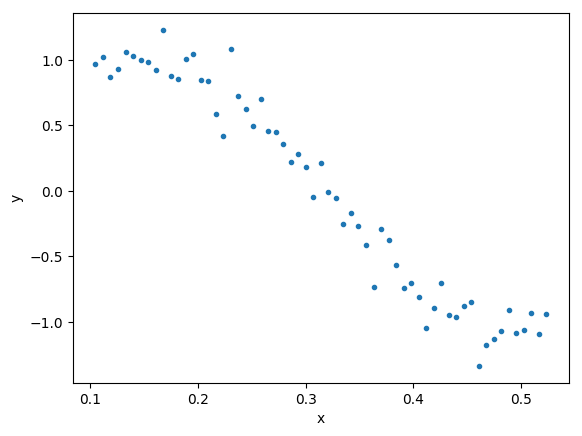

In [94]:
using PyPlot

#=  # This code generated the data!
srand(0)
x = pi/180 * (60:4:300)
n = length(x)
y = sin.(x) + 0.15*randn(n)
x = x/10
writecsv("lasso_data.csv",[x y])
=#

data = readcsv("lasso_data.csv")
x = data[:,1]
y = data[:,2]
plot(x,y,".")
xlabel("x"); ylabel("y");

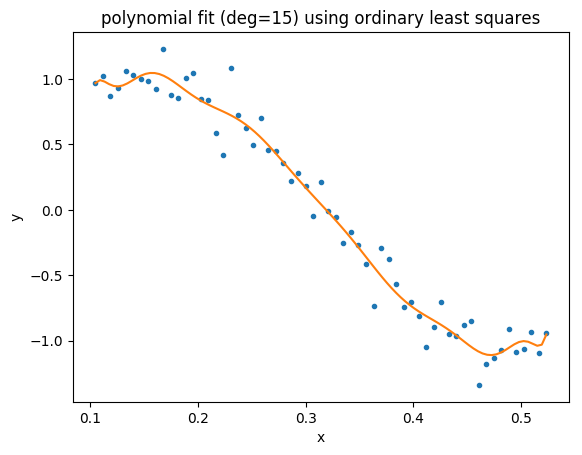

In [66]:
# ORDINARY LEAST SQUARES

d = 15
A = zeros(n,d+1)
for j = 1:d+1
    A[:,j] = x.^(j-1)
end
what = A\y

N = 100
xfine = linspace(x[1],x[end],N)
Afine = zeros(N,d+1)
for j = 1:d+1
    Afine[:,j] = xfine.^(j-1)
end

yhat = Afine*what

plot(x,y,".")
plot(xfine,yhat,"-")
title(string("polynomial fit (deg=", d, ") using ordinary least squares"))
xlabel("x"); ylabel("y");

In [65]:
# we observe that the coefficients in the fit for d=15 are VERY large!!!

what

16-element Array{Float64,1}:
 -2540.57      
     1.36403e5 
    -3.25136e6 
     4.54817e7 
    -4.15328e8 
     2.60173e9 
    -1.1401e10 
     3.47785e10
    -7.10743e10
     8.62769e10
    -3.31005e10
    -5.7546e10 
     6.3459e10 
     3.71847e10
    -9.21523e10
     4.22599e10

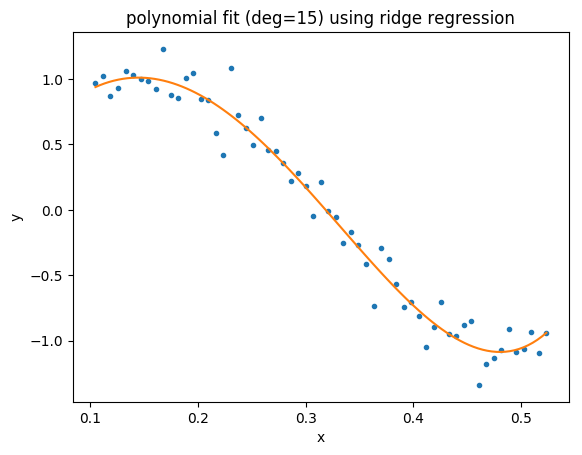

In [76]:
# RIDGE REGRESSION TO MAKE COEFFICIENTS SMALLER

μ = 1e-6
what = (A'*A + μ*eye(d+1))\(A'*y)

N = 100
xfine = linspace(x[1],x[end],N)
Afine = zeros(N,d+1)
for j = 1:d+1
    Afine[:,j] = xfine.^(j-1)
end

yhat = Afine*what

plot(x,y,".")
plot(xfine,yhat,"-")
title(string("polynomial fit (deg=", d, ") using ridge regression"))
xlabel("x"); ylabel("y");

In [74]:
# Using ridge regression, the parameters are much smaller!

what

16-element Array{Float64,1}:
  -0.00544862
  14.6022    
 -55.0324    
  11.6286    
  42.0642    
  33.919     
  16.5014    
   3.71181   
  -2.5878    
  -4.50957   
  -4.29447   
  -3.3504    
  -2.35425   
  -1.54971   
  -0.97555   
  -0.594575  

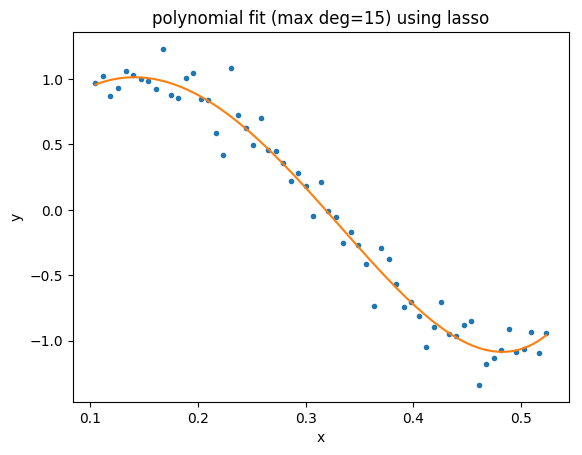

Academic license - for non-commercial use only
number of zero entries is: 11


In [88]:
d = 15
A = zeros(n,d+1)
for j = 1:d+1
    A[:,j] = x.^(j-1)
end

using JuMP, Gurobi, Mosek
λ = 0.001

m = Model(solver=GurobiSolver(OutputFlag=0))
#m = Model(solver=MosekSolver(LOG=0))

@variable(m, w[1:d+1])
@variable(m, t[1:d+1])
@expression(m, LS, sum((A*w-y).^2))
@expression(m, L1, sum(t))
@constraint(m,  w .<= t)
@constraint(m, -w .<= t)
@objective(m, Min, LS + λ*L1)
solve(m)

wopt = getvalue(w)

# do some thresholding
ix = find(abs.(wopt) .< 1e-5)
println("number of zero entries is: ", length(ix))
wopt[ix] = 0

Afine = zeros(N,d+1)
for j = 1:d+1
    Afine[:,j] = xfine.^(j-1)
end
yhat = Afine*wopt

plot(x,y,".")
plot(xfine,yhat,"-")
title(string("polynomial fit (max deg=", d, ") using lasso"))
xlabel("x"); ylabel("y");

In [89]:
# Using lasso, we get a sparse model:

wopt

16-element Array{Float64,1}:
   0.119138
  13.0344  
 -48.5436  
   0.0     
  50.3671  
  41.1857  
   0.0     
   0.0     
   0.0     
   0.0     
   0.0     
   0.0     
   0.0     
   0.0     
   0.0     
   0.0     